#  🍰 Parameter subset training

The following example demonstrates how to train a subset of parameters

In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet

First, full parameter training is demonstrated.

linear1.weight before training
[[ 1.5566283 -1.6665335  1.4389884 -1.0703712  0.2445326 -1.0884298
  -1.2858775  1.6523795 -1.1615381 -0.1716814]]
linear2.weight before training
[[ 0.4221825 ]
 [-0.2719926 ]
 [-0.1374367 ]
 [-0.04014226]
 [ 0.39653325]
 [ 0.6115301 ]
 [ 0.25633797]
 [-0.28208828]
 [-0.57896185]
 [-0.84625894]]
linear1.weight after training
[[ 1.5091101  -1.6033007   1.5654734  -1.091966    0.32660955 -1.4726009
  -1.542354    1.8473767  -1.0972728  -0.34225878]]
linear2.weight after training
[[ 0.7347251 ]
 [-0.26030147]
 [-0.7558785 ]
 [ 0.2405407 ]
 [ 0.50954366]
 [ 1.4544754 ]
 [ 1.0004135 ]
 [-1.2522283 ]
 [-0.81760883]
 [-0.9254845 ]]


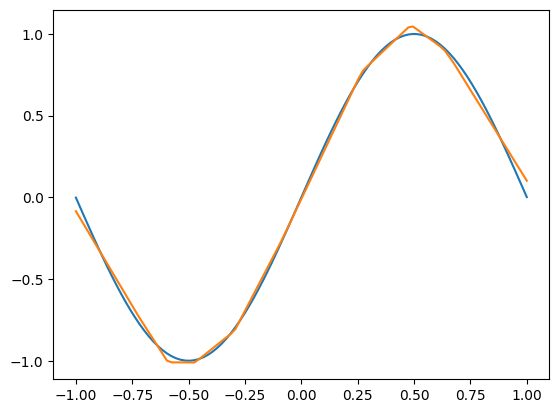

In [2]:
import serket as sk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


class Net(sk.TreeClass):
    def __init__(self, key):
        k1, k2 = jax.random.split(key, 2)
        self.linear1 = sk.nn.Linear(
            in_features=1,
            out_features=10,
            weight_init="he_normal",
            key=k1,
        )
        self.linear2 = sk.nn.Linear(
            in_features=10,
            out_features=1,
            weight_init="he_normal",
            key=k2,
        )

    def __call__(self, x):
        return self.linear2(jax.nn.relu(self.linear1(x)))


net = Net(key=jax.random.PRNGKey(0))
net = sk.tree_mask(net)
x = jnp.linspace(-1, 1, 100)[..., None]
y = jnp.sin(x * 3.14)


@jax.jit
def train_step(net: Net, x: jax.Array, y: jax.Array) -> Net:
    def loss_func(net, x, y):
        ypred = jax.vmap(sk.tree_unmask(net))(x)
        loss = jnp.mean((ypred - y) ** 2)
        return loss

    grad = jax.grad(loss_func)(net, x, y)
    net = jax.tree_map(lambda p, g: p - 1e-2 * g, net, grad)
    return net


print("linear1.weight before training")
print(net.linear1.weight)
print("linear2.weight before training")
print(net.linear2.weight)

for i in range(10_000):
    net = train_step(net, x, y)
net = sk.tree_unmask(net)

plt.plot(x, y, label="true")
plt.plot(x, jax.vmap(net)(x), label="pred")

print("=" * 100)
print("linear1.weight after training")
print(net.linear1.weight)
print("linear2.weight after training")
print(net.linear2.weight)

Now, lets train only `linear2` and exclude `linear1`, by simply applying `sk.freeze` on `linear1` without changing anything else.

linear1.weight before training
[[ 1.5566283 -1.6665335  1.4389884 -1.0703712  0.2445326 -1.0884298
  -1.2858775  1.6523795 -1.1615381 -0.1716814]]
linear2.weight before training
[[ 0.4221825 ]
 [-0.2719926 ]
 [-0.1374367 ]
 [-0.04014226]
 [ 0.39653325]
 [ 0.6115301 ]
 [ 0.25633797]
 [-0.28208828]
 [-0.57896185]
 [-0.84625894]]
linear1.weight after training
[[ 1.5566283 -1.6665335  1.4389884 -1.0703712  0.2445326 -1.0884298
  -1.2858775  1.6523795 -1.1615381 -0.1716814]]
linear2.weight after training
[[ 0.6010599 ]
 [-0.396584  ]
 [ 0.02793936]
 [-0.12015507]
 [ 0.42463148]
 [ 0.53014684]
 [ 0.1602112 ]
 [-0.09219106]
 [-0.66580254]
 [-0.85910016]]


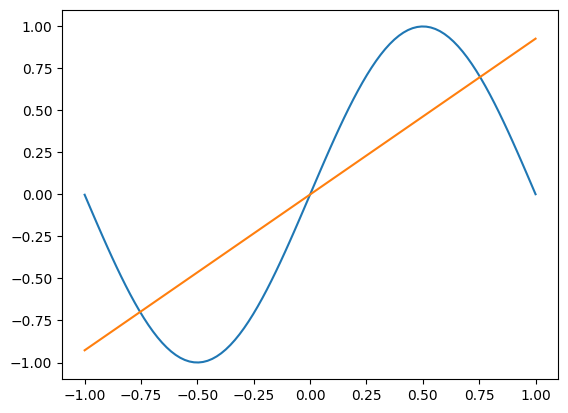

In [3]:
net = Net(key=jax.random.PRNGKey(0))
net = sk.tree_mask(net)

print("linear1.weight before training")
print(net.linear1.weight)
print("linear2.weight before training")
print(net.linear2.weight)

# exclude `linear1` by freezing it
net = net.at["linear1"].apply(sk.freeze)

for i in range(10_000):
    net = train_step(net, x, y)

net = sk.tree_unmask(net)
plt.plot(x, y, label="true")
plt.plot(x, jax.vmap(net)(x), label="pred")

print("=" * 100)
print("linear1.weight after training")
print(net.linear1.weight)
print("linear2.weight after training")
print(net.linear2.weight)

From the printout, `linear2` has changed while `linear1` has not. Also the ability to learn has decreased significantly.

Another possibility is that we can freeze/unfreeze based on a condition. For example, we can start by training full parameters and then later on we can optimize the layers near the head.